# Predicting Employee Attrition using Logistic Regression (Cont'd)

## Analysis of Features and Comparison between Sci-kit Learn - Statsmodels Libraries 

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure

## Introduction

(Note, this notebook is a continuation from previous one at https://github.com/TaufiekDida/EmployeeAtrrition_v01/blob/main/HR%20Analytics_v01.ipynb)

**"Why does the very same dataset, may generate different models, different coefficients, and show different performance by different libraries?"**

If you ever wondered how different some popular Python libraries for statistical-machine learning analysis for generating predictive model, then this notebook will provide some comparison of two most popular libraries i.e. sci-kit learn (popularly known as sklearn) and statsmodels. This notebook will cover characteristics, default settings, differences (and similiraties) of sci-kit learn and statsmodel, and how well they perform for the given dataset using logistics regression.

There are 3 scenarios that will be run on this notebook:
    1. sci-kit learn default settings
    2. sci-kit learn modified (unpenalized) settings
    3. statsmodel intercept-fitted settings
    
Note that based on sci-kit learn documentation, by default, sci-kit learn produces penalized model (that is, applying "penalty" by scaling down features with high coefficients). Refer to this article to read more: https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegression.html

Also note that statsmodels library by default does not fit the intercept of the model, thus to make it more comparable to its sci-kit counterpart, add_constant method is applied. Refer to this thread to read more: https://stackoverflow.com/questions/38836465/how-to-get-the-regression-intercept-using-statsmodels-api

Exploratory Data Analysis is skipped in this notebook as it was done in previous article. To skip the cleansing and transforming part, go to the "Creating the Model" part.

## Data cleansing, Exploratory Data Analysis, and Data Transformation

In [2]:
os.chdir(r"F:\Python\Database\HR Analytics")
data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
# Swapping 'Age' and 'Attrition' columns so that the dependent variable 'Attrition' goes to the front.
swap = ['Attrition',
 'Age',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']
data=data.reindex(columns=swap)

<br>
Converting binary values such as "Yes" or "No" to 1 and 2 respectively. 
For "BusinessTravel", 0 indicates Non-Travel, 1 indicates rarely, 2 indicates frequently.
For genders, 0 indicates male and 1 indicates female.

'Over18', 'StandardHours, and 'EmployeeCount columns contain same values for all rows which are meaningless in the analysis, and thus are dropped.
'EmployeeNumber', 'Department', 'EducationField', 'JobRole', and 'MaritalStatus' columns are also dropped as rather considered irrelevant.

In [4]:
# converting to numerical and ordinal values. Also dropping irrelevant columns
dropped = ['EmployeeNumber', 'StandardHours', 'EmployeeCount', 'Over18','Department', 'EducationField', 'JobRole', 'MaritalStatus']
data2 = data.replace({'Yes':1, 'No':0, 'Non-Travel':0, 'Travel_Rarely':1,'Travel_Frequently':2,'Male':0,'Female':1})
data2 = data2.drop(dropped,axis=1)

Checking for outliers within the dataframe. Some outliers are still acceptable to be used in the analysis as long as they are follow common sense.
The steps are:<br>
    1. Identifying binary (nominal) variables, those variables will be excluded from outliers detecting process<br>
    2. Constructing thresholds for outliers, one of the most widely used is using Inter-quartile Range (IQR)<br>
    3. Determining columns that are containing outliers<br>
    


In [26]:
# Determining binary (nominal) variables
binary = []
for i in data2:
    if len(data2[i].unique())==2:
        binary.append(i)
binary

# Apparently, PerformanceRating is only showing 2 unique values i.e. [3,4] even though they are not nominal variable. 
# Nonetheless, it is still unnecessary to include them in outliers detection

['Attrition', 'Gender', 'OverTime', 'PerformanceRating']

In [6]:
# Determining IQR
Q1 = data2.quantile(0.25)
Q3 = data2.quantile(0.75)
IQR = Q3 - Q1


In [7]:
# Determining columns that are containing outliers by using indexing

index = (((data2.min() < (Q1 - 1.5 * IQR)) | (data2.max() > (Q3 + 1.5 * IQR))) & ~data2.columns.isin(binary))
outliercols = data2.columns[index]
outliercols

Index(['BusinessTravel', 'MonthlyIncome', 'NumCompaniesWorked',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [8]:
# Checking for the values that are outside Inter-quartile Range for each columns (outliers).
((data2 < (Q1 - 1.5 * IQR)) | (data2 > (Q3 + 1.5 * IQR))).sum().sort_values(ascending = False)

# The 'BusinessTravel' columns has the most rows that contain outliers

BusinessTravel              427
TrainingTimesLastYear       238
Attrition                   237
PerformanceRating           226
MonthlyIncome               114
YearsSinceLastPromotion     107
YearsAtCompany              104
StockOptionLevel             85
TotalWorkingYears            63
NumCompaniesWorked           52
YearsInCurrentRole           21
YearsWithCurrManager         14
JobSatisfaction               0
Age                           0
JobLevel                      0
OverTime                      0
PercentSalaryHike             0
JobInvolvement                0
RelationshipSatisfaction      0
HourlyRate                    0
Gender                        0
EnvironmentSatisfaction       0
WorkLifeBalance               0
Education                     0
DistanceFromHome              0
DailyRate                     0
MonthlyRate                   0
dtype: int64

In [9]:
# Printing values in the outlier columns to c
for i in outliercols:
    if len(data2[i].unique()) < 5: 
        print(i)
        print(sorted(data2[i].unique(),reverse=True),end='\n\n')
    else:
        print(i)
        print(sorted(data2[i].unique(),reverse=True)[0:5],"...", sorted(data2[i].unique(),reverse=True)[-5:],end='\n\n')

BusinessTravel
[2, 1, 0]

MonthlyIncome
[19999, 19973, 19943, 19926, 19859] ... [1091, 1081, 1052, 1051, 1009]

NumCompaniesWorked
[9, 8, 7, 6, 5] ... [4, 3, 2, 1, 0]

StockOptionLevel
[3, 2, 1, 0]

TotalWorkingYears
[40, 38, 37, 36, 35] ... [4, 3, 2, 1, 0]

TrainingTimesLastYear
[6, 5, 4, 3, 2] ... [4, 3, 2, 1, 0]

YearsAtCompany
[40, 37, 36, 34, 33] ... [4, 3, 2, 1, 0]

YearsInCurrentRole
[18, 17, 16, 15, 14] ... [4, 3, 2, 1, 0]

YearsSinceLastPromotion
[15, 14, 13, 12, 11] ... [4, 3, 2, 1, 0]

YearsWithCurrManager
[17, 16, 15, 14, 13] ... [4, 3, 2, 1, 0]



Based on the outlier detection, it is can be seen that these outliers are still considered to be naturally occuring in real world (workplace condition). Removal of these data points may lead to unrepresentative and biased predictor model.

In [10]:
# Normalizing dataframe using max-min normalization
data2=(data2-data2.min())/(data2.max()-data2.min())

## Creating the model

In [11]:
# Splitting the dataframe to dependent variable Y ('Attrition') and independent variables X's
X =  data2.iloc[:,1:].values
Y = data2.iloc[:,0].values

The dataset is divided by using proportion of training set : test set = 0.667 : 0.333 respectively. Other ratio may be applicable and can be compared with this results. Other commonly ratios are 80:20, 70:20, 75:25, etc.

In [12]:
# Splitting the dataframe into training set and test set in 0.667 : 0.333 proportion respectively
# note that random_state=42 is purely arbitrary value, this value remains unchanged to compensate the existing previous version
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.333, random_state=42) 


In [13]:
# Creating model based on Sklearn default settings
# sklearn LogisticRegression is using penalized model as default.

from sklearn.linear_model import LogisticRegression

# Instantiate logistic regression using sklearn
logres_def = LogisticRegression()

# Fitting the model (Training)
logres_def.fit(X_train, Y_train)

# Creating prediction based on the Logistic Regression model
ypredlogres_def = logres_def.predict(X_test)

In [14]:
# Creating model based on Sklearn modified settings
# this setting will be removing penalty (regularization) from the model

from sklearn.linear_model import LogisticRegression

# Instantiate logistic regression using sklearn
logres_mod = LogisticRegression(penalty='none')

# Fitting the model (Training)
logres_mod.fit(X_train, Y_train)

# Creating prediction based on the Logistic Regression model
ypredlogres_mod = logres_mod.predict(X_test)

In [15]:
# Creating model based on Statsmodels settings,
# Note, statsmodels does not automatically fit the intercept (bias) on the model. 
# So sm.add_constant method is used within the Logit method to fit intercept
# Also, note that statsmodels does not generate penalized model.

import statsmodels.api as sm

logit_model_train=sm.Logit(Y_train, sm.add_constant(X_train))
logit_model_test=sm.Logit(Y_test, sm.add_constant(X_test))

logres_sm=logit_model_train.fit()

Optimization terminated successfully.
         Current function value: 0.320444
         Iterations 8


## Model Evaluation and Features (Coefficients) Analysis of all 3 Scenarios

Accuracy score is defined as: 

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

Where TP, TN, FP, FN stands for True Positive, True Negative, False Positive, and False Negative respectively

However, as the data itself is imbalanced, accuracy may not be the best metric for imbalanced data set. These articles https://stephenallwright.com/imbalanced-data-metric/, https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/, https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a provide suggestions on using other metrics such as F1-score, Receiver Operating Characteristics-Area Under the Curve (ROC-AUC), and Matthew's Correlation Coefficient (MCC).

In [16]:
#display regression coefficients for sklearn's default settings model

training_score_def = logres_def.score(X_train,Y_train)
test_score_def = logres_def.score(X_test,Y_test)

print("Training set accuracy score of Sklearn's default settings model: {:.3f}".format(training_score_def))
print("Test set score accuracy of Sklearn's default settings model: {:.3f}".format(test_score_def))

Training set accuracy score of Sklearn's default settings model: 0.871
Test set score accuracy of Sklearn's default settings model: 0.873


In [27]:
#display regression coefficients for sklearn's modified settings model

training_score_mod = logres_mod.score(X_train,Y_train)
test_score_mod = logres_mod.score(X_test,Y_test)

print("Training set accuracy score of Sklearn's unpenalized (modified) model: {:.3f}".format(training_score_mod))
print("Test set accuracy score Sklearn's unpenalized (modified) model: {:.3f}".format(test_score_mod))


Training set accuracy score of Sklearn's unpenalized (modified) model: 0.878
Test set accuracy score Sklearn's unpenalized (modified) model: 0.876


In [29]:
# display regression coefficients for statsmodels' modified settings model
# statsmodels accuracy score are adapted from https://blog.finxter.com/logistic-regression-scikit-learn-vs-statsmodels/

sm_train_predicted = logres_sm.predict(sm.add_constant(X_train))>.5
sm_test_predicted = logres_sm.predict(sm.add_constant(X_test))>.5

sm_train_score = (Y_train==sm_train_predicted).mean()
sm_test_score = (Y_test==sm_test_predicted).mean()


print("Training set accuracy score of statsmodel default model: {:.3f}".format(sm_train_score))
print("Test set accuracy score of statsmodel default model: {:.3f}".format(sm_test_score))


Training set accuracy score of statsmodel default model: 0.878
Test set accuracy score of statsmodel default model: 0.876


In [19]:
# Comparison between models based on accuracy score

lst = [['Default Sci-kit Model', logres_def.score(X_train, Y_train),logres_def.score(X_test, Y_test)],
       ['Unpenalized Sci-kit Model',logres_mod.score(X_train, Y_train),logres_mod.score(X_test, Y_test)],
       ['Statsmodel Intercept Fitting Model',sm_train_score,sm_test_score]
       ]
accuracy_compare = pd.DataFrame(lst, columns =['Settings', 'train set accuracy','test set accuracy'])
accuracy_compare

,Settings,train set accuracy,test set accuracy
0,Default Sci-kit Model,0.871429,0.873469
1,Unpenalized Sci-kit Model,0.877551,0.875510
2,Statsmodel Intercept Fitting Model,0.877551,0.875510


In [20]:
# Comparison between models based on coefficients

# Defining variable names i.e. x1, x2, ...
var = ['intercept']
for i in range(1,27):
    var.append(f'x{i}')

# declaring coefficients of each scenarios
logres_def_coef = logres_def.intercept_.tolist()+list(logres_def.coef_[0])
logres_mod_coef = logres_mod.intercept_.tolist()+list(logres_mod.coef_[0])
sm_intercepted_coef = list(logres_sm.params)


In [21]:
data_coef = { 'Parameters' : var,
       'Sci-kit Default Settings' : logres_def_coef,
       'Scikit Unpenalized Settings' : logres_mod_coef,
      'Statsmodel with Intercept Fitting' : sm_intercepted_coef
      }
coef_compare = pd.DataFrame(data_coef)
coef_compare

,Parameters,Sci-kit Default Settings,Scikit Unpenalized Settings,Statsmodel with Intercept Fitting
0,intercept,0.727020,1.233798,1.233657
1,x1,-1.062362,-0.933713,-0.933523
2,x2,1.308017,1.678671,1.678705
3,x3,-0.210845,-0.183228,-0.183255
4,x4,0.884067,1.063751,1.063769
5,x5,0.227763,0.383271,0.383350
6,x6,-0.876566,-1.105173,-1.105172
7,x7,-0.289694,-0.378589,-0.378605
8,x8,-0.091113,-0.142439,-0.142498
9,x9,-1.545829,-1.909847,-1.909820


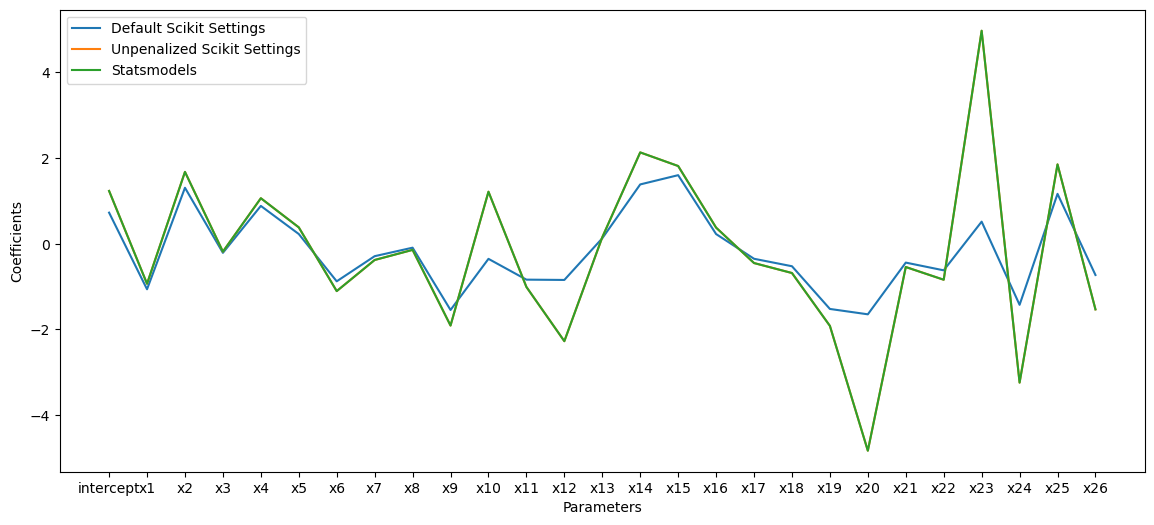

In [22]:
x = [i for i in var]

plt.figure(figsize=(14,6))
plt.plot(x, logres_def_coef, label = 'Default Scikit Settings')
plt.plot(x, logres_mod_coef, label = 'Unpenalized Scikit Settings')
plt.plot(x, sm_intercepted_coef, label = 'Statsmodels')


plt.xlabel('Parameters')
plt.ylabel('Coefficients')
plt.legend()

plt.show()


**Coeficients Table Comparison**

Based on the coefficients table, we can see that cofficient values from **sci-kit default settings are unsurprisingly differ greatly** from sci-kit unpenalized settings and statsmodels with intercept fitting. On the other hand, results from **sci-kit unpenalized settings and statsmodels with intercept fitting are relatively equivalent** at 3 decimal places thus they are almost indifferent within the graph. It is important to consider what library that should be used and what settings should be applied prior to creating a model.

**Coefficients Graph Comparison**

Based on the parameters vs coefficients graph, we can see that unpenalized scikit and statsmodels lines are coinciding, thus seem to be indistinguishable. We can see the effect of penalization on default sci-kit settings, the very high coefficients value in unpenalized settings such as x10, x12, x20, x23, and x24 are penalized or "surpressed" to much lower (close to 0) values.

In [30]:
# True Positives, True Negatives, False Positives, and False Negatives comparison

# Returning some important metrics
# code adpated from https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5
def test_results(y_true, y_score):
    test_res = []
    # True positive
    tp = np.sum(y_true * y_score)
    test_res.append(tp)
    
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    test_res.append(tn)
    
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    test_res.append(fp)
    
    # False negative
    fn = np.sum(y_true * (y_score==0))
    test_res.append(fn)
    
    # Empty Parameters List: 
    return test_res

tests = ['TP','TN','FP','FN']

conf_mat = {'tests' : tests, 
           'Sci-kit Default Settings' : test_results(Y_test, (ypredlogres_def > 0.5).astype(int)), 
           'Sci-kit Unpenalized Settings' : test_results(Y_test, (ypredlogres_mod > 0.5).astype(int)),
           'Statsmodel with Intercept Fitting' : test_results(Y_test, (sm_test_predicted > 0.5).astype(int))}

pd.DataFrame(conf_mat)

,tests,Sci-kit Default Settings,Sci-kit Unpenalized Settings,Statsmodel with Intercept Fitting
0,TP,15.0,22.0,22.0
1,TN,413.0,407.0,407.0
2,FP,6.0,12.0,12.0
3,FN,56.0,49.0,49.0


In [24]:
# Returning some important metrics
# code adpated from https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5
def show_metrics(y_true, y_score):
    
    
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))
    
    # Empty Parameters List:
    metrics = []
    
    
    # Accuracy
    acc = (tp+tn)/(fp+fn+tp+tn)
    metrics.append(acc)

    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    metrics.append(tpr)
    
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    metrics.append(fpr)
    
    # Precision
    precision = tp / (tp + fp)
    metrics.append(precision)
    
    # True negatvie rate (specificity)
    tnr = 1 - fpr
    metrics.append(tnr)
    
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    metrics.append(f1)
    
    # ROC-AUC for binary classification
    auc = (tpr+tnr) / 2
    metrics.append(auc)
    
    # MCC
    mcc = (tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    metrics.append(mcc)
    
    return metrics

In [25]:
# Showing metrics based on test set models of 3 scenarios

metrics = ['Accuracy',
          'True Positive Rate (TPR/ Sensitivity/ Recall)',
           'False Positive Rate (Fall-out)',
           'Precision',
           'True Negative Rate (TNR/ Specificity)',
           'F1 score',
           'ROC-AUC',
           'MCC'
          ]

data_metrics = {'Metrics' : metrics, 
                'Sci-kit Default Settings': show_metrics(Y_test, (ypredlogres_def > 0.5).astype(int)),
               'Sci-kit Unpenalized Settings' : show_metrics(Y_test, (ypredlogres_mod > 0.5).astype(int)),
                'Statsmodel with Intercept Fitting' : show_metrics(Y_test, (sm_test_predicted > 0.5).astype(int))
               }
metrics_compare = pd.DataFrame(data_metrics)
metrics_compare

,Metrics,Sci-kit Default Settings,Sci-kit Unpenalized Settings,Statsmodel with Intercept Fitting
0,Accuracy,0.873469,0.875510,0.875510
1,True Positive Rate (TPR/ Sensitivity/ Recall),0.211268,0.309859,0.309859
2,False Positive Rate (Fall-out),0.014320,0.028640,0.028640
3,Precision,0.714286,0.647059,0.647059
4,True Negative Rate (TNR/ Specificity),0.985680,0.971360,0.971360
5,F1 score,0.326087,0.419048,0.419048
6,ROC-AUC,0.598474,0.640610,0.640610
7,MCC,0.342288,0.389547,0.389547


**Conclusions**

Based on the results, we can see that **sci-kit unpenalized settings is equivalent statsmodels default settings** with intercept fitting. Surprisingly, scikit unpenalized settings and statsmodels default settings provide better Accuracy, Recall, F1 score, ROC-AUC, and MCC evaluation metrics. 



It is very important to understand the characteristics of each library along with its features and limitations before performing any statistical analysis or model creation.